In [1]:
%matplotlib inline
import pylab as pl
from astropy.io import fits
import numpy as np
from astropy import units as u

# Load the data

In [2]:
ne_image = fits.getdata('data/Light_neon17.50mm_1sec_Bin2_0.0C_gain0_2024-09-03_105405_frame0001.fit')
solar_image = fits.getdata('data/Light_sun17.50mm_5sec_Bin2_-0.3C_gain0_2024-09-03_104925_frame0001.fit')

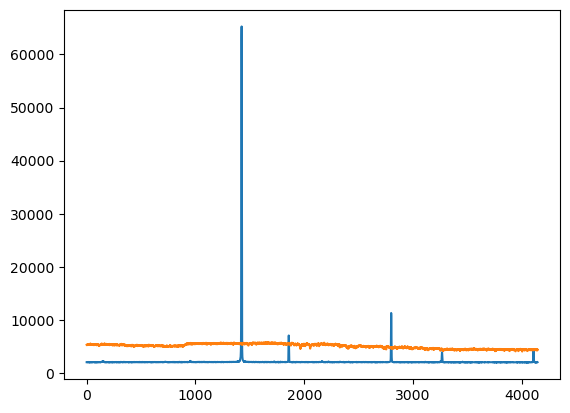

In [3]:
ne_spectrum = ne_image[1200,:]
pl.plot(ne_spectrum)
pl.plot(solar_image[1200, :]);

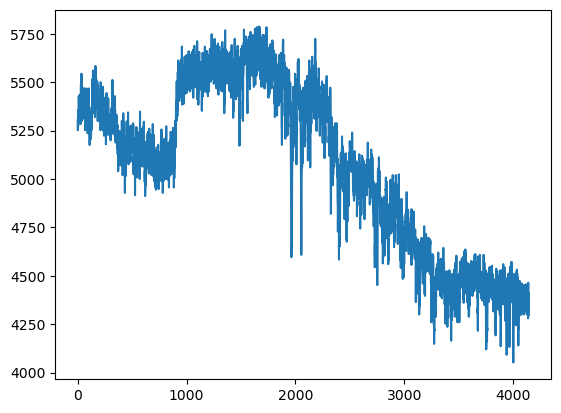

In [4]:
pl.plot(solar_image[1200, :]);

# Input initial guesses

In [5]:
guesspix = [1862, 2800, 1419, 3267, 2163, 2223, 948, 146, 4104]
guess_wl = [5881.895, 5944.834, 5852.488, 5975.534, 5902.462, 5906.429, 5820.156, 5764.419, 6029.997]
xaxis = np.arange(ne_image.shape[1])

## Fit initial guesses

In [6]:
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

In [7]:
from astropy.modeling.models import Linear1D
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=guesspix, y=guess_wl)
wavelengths = linfit_wlmodel(xaxis) * u.AA
linfit_wlmodel

<Linear1D(slope=0.06705376, intercept=5756.52802246)>

## Improve guesses

In [8]:
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in guesspix]
improved_xval_guesses

[1856.959135744481,
 2798.5090544871796,
 1423.3926714260533,
 3264.485849056604,
 2163.1440217391305,
 2222.4506172839506,
 951.5189620758483,
 148.18491921005386,
 4106.050637271788]

In [9]:
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guess_wl)
wavelengths = linfit_wlmodel(xaxis) * u.AA
linfit_wlmodel

<Linear1D(slope=0.06711112, intercept=5756.38726087)>

## Plot fit & residual

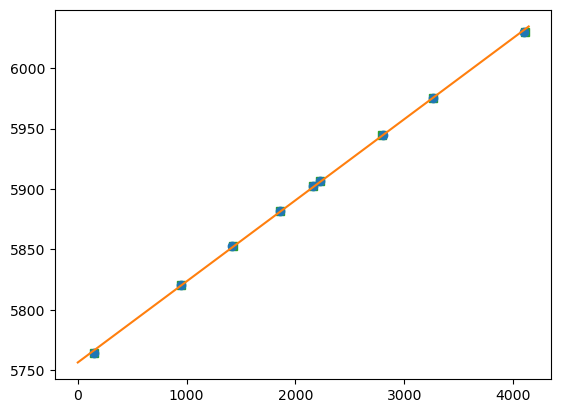

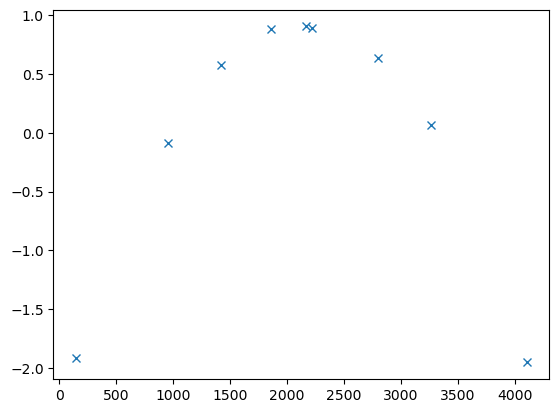

In [10]:
pl.plot(guesspix, guess_wl, 'o')
pl.plot(xaxis, wavelengths, '-')
pl.plot(improved_xval_guesses, guess_wl, 's', zorder=-5)
pl.figure()
pl.plot(improved_xval_guesses, (guess_wl - linfit_wlmodel(improved_xval_guesses)), 'x')

## Refit with higher order

In [11]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [12]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, improved_xval_guesses, guess_wl)
wavelengths = fitted_polymodel(xaxis) * u.AA

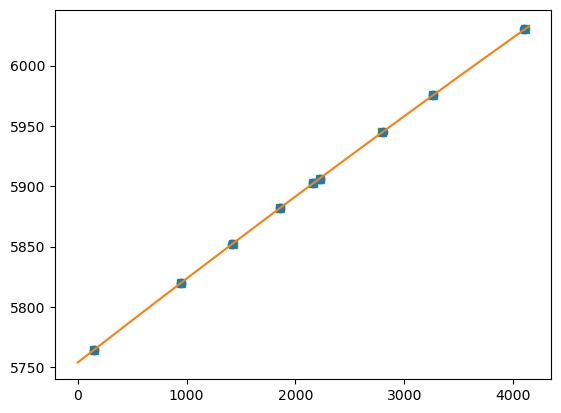

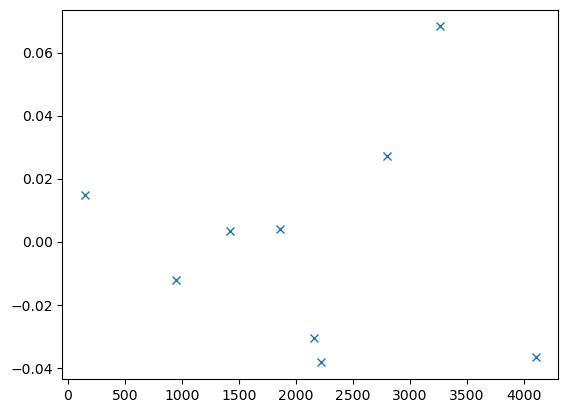

In [13]:
pl.plot(guesspix, guess_wl, 'o')
pl.plot(xaxis, fitted_polymodel(xaxis), '-')
pl.plot(improved_xval_guesses, guess_wl, 's', zorder=-5)
pl.figure()
pl.plot(improved_xval_guesses, (guess_wl - fitted_polymodel(improved_xval_guesses)), 'x')

# Query line catalog

In [14]:
from astroquery.nist import Nist
minwave = wavelengths.min()
maxwave = wavelengths.max()
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        wavelength_type='vac+air',
                        linename='Ne I')

In [15]:
neon_lines.pprint(max_lines=40, max_width=1000);

 Observed    Ritz   Transition  Rel.    Aki       fik    Acc.       Ei           Ek                    Lower level                         Upper level             gi   gk Type   TP   Line
--------- --------- ---------- ----- ---------- -------- ---- ---------------------------- ----------------------------------- ----------------------------------- ------- ---- ----- -----
5760.5885 5760.5882 17354.5243   700   506000.0   0.0018   C+ 18.55510805  -   20.70679493 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[3/2]* | 2   7 - 5   -- T6976 L3451
5764.0525  5764.053  17344.095    30   550000.0  0.00274   C+ 18.55510805  -   20.70550158 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[7/2]* | 3   7 - 7   -- T6976 L4498
5764.4188 5764.4189 17342.9928  7000 11200000.0   0.0717    B 18.55510805  -   20.70536507 2s2.2p5.(2P*<3/2>).3p | 2[5/2]  | 3 2s2.2p5.(2P*<3/2>).4d | 2[7/2]* | 4   7 - 9   -- T6976 L3451
5770.3067 5770.3132  17325.297   500   404000.0  0.00606   C

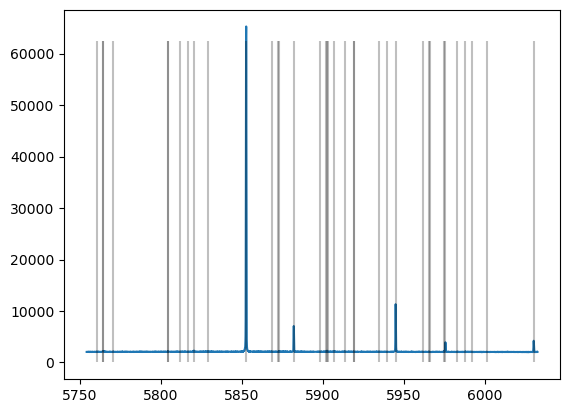

In [16]:
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'], 0, 62500, 'k', alpha=0.25)

## Downselect bright lines

In [17]:
# these lines downselect from the table to keep only those that have usable "Relative Intensity" measurements
# first, we get rid of those whose 'Rel.' column is masked out or is an asterisk
ne_keep = (neon_lines['Rel.'] != "*")
ne_wl_tbl = neon_lines['Observed'][ne_keep]
# then, we collect the 'Rel.' values and convert them from strings to floats
ne_rel_tbl = np.array([float(x) for x in neon_lines['Rel.'][ne_keep]])
ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max()

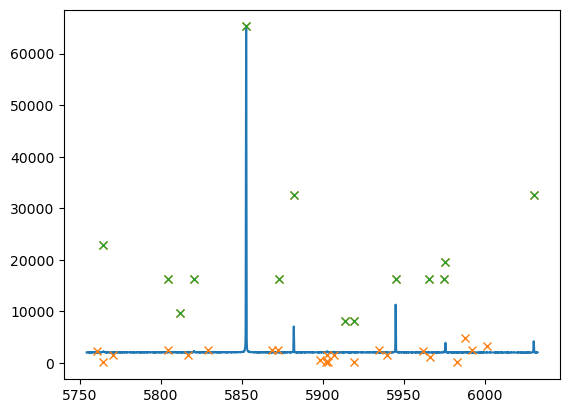

In [18]:
pl.plot(wavelengths, ne_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
pl.plot(ne_wl_tbl, ne_rel_intens, 'x')
ne_keep_final = ne_rel_intens > 5000
pl.plot(ne_wl_tbl[ne_keep_final], ne_rel_intens[ne_keep_final], 'x')

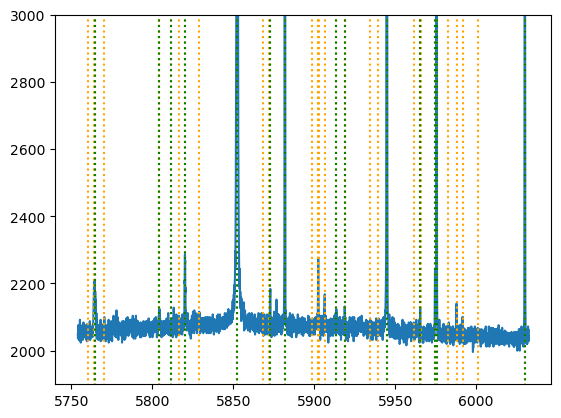

In [19]:
pl.plot(wavelengths, ne_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
pl.vlines(ne_wl_tbl, 0, 60000, color='orange', linestyle=':')
pl.vlines(ne_wl_tbl[ne_keep_final], 0, 60000, color='g', linestyle=':')
pl.ylim([1900, 3000]);

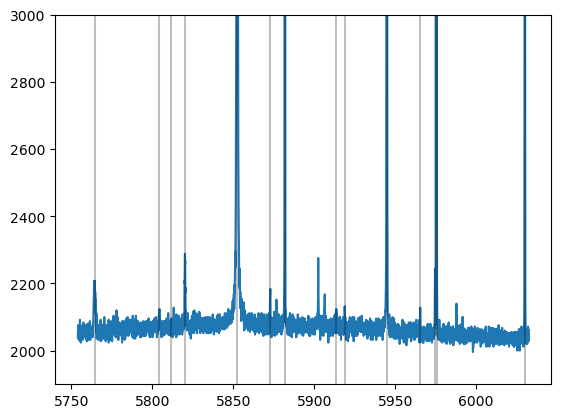

In [20]:
ne_spectrum = ne_image[1200,:]
pl.plot(wavelengths, ne_spectrum)
pl.vlines(neon_lines['Observed'][ne_keep_final], 0, 62500, 'k', alpha=0.25)
pl.ylim(1900, 3000);

## Convert bright lines to pixel predictions

In [21]:
def inverse_polymodel(wl, xaxis=xaxis, wavelengths=wavelengths):
    return np.interp(wl, wavelengths, xaxis)

In [22]:
# select down to just those lines we want to keep
ne_wl_final = ne_wl_tbl[ne_keep_final]
# linear isn't good enough.  ne_pixel_vals = linfit_wlmodel.inverse(ne_wl_final)
ne_pixel_vals = inverse_polymodel(ne_wl_final)

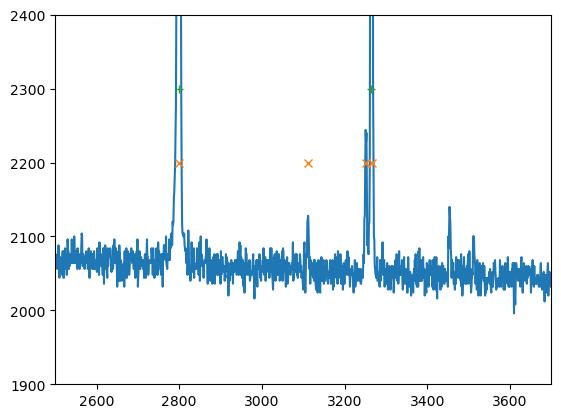

In [23]:
# check for overlaps again (in the densest part of the spectrum)
pl.plot(xaxis, ne_spectrum)
pl.plot(ne_pixel_vals, [2200]*len(ne_pixel_vals), 'x')
pl.plot(improved_xval_guesses, [2300] * len(improved_xval_guesses), '+')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    pl.plot([xx-15,xx+15], [yy,yy], )
pl.xlim(2500, 3700)
pl.ylim(1900, 2400);

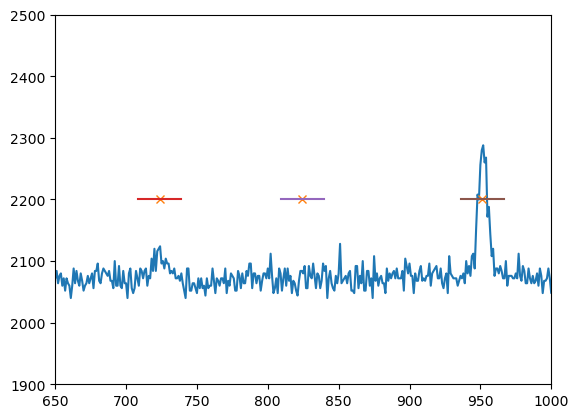

In [24]:
# check for overlaps again (in the densest part of the spectrum)
pl.plot(xaxis, ne_spectrum)
pl.plot(ne_pixel_vals, [2200]*len(ne_pixel_vals), 'x')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    pl.plot([xx-15,xx+15], [2200, 2200], )
pl.xlim(650,1000)
pl.ylim(1900, 2500);

## Measure bright line pixel locations

In [25]:
npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in map(int, ne_pixel_vals)]
improved_xval_guesses_ne

[147.41980198019803,
 723.4573643410853,
 830.05,
 951.6221294363256,
 1423.497135292089,
 1722.1472081218274,
 1856.8768309970073,
 2329.5342465753424,
 2408.6315789473683,
 2798.5041188822483,
 3109.0285714285715,
 3253.439330543933,
 3265.169099756691,
 4105.942521008404]

## Refit with line list

In [26]:
refitted_polymodel = linfitter(polymodel, improved_xval_guesses_ne, ne_wl_final)
wavelengths_refit = refitted_polymodel(xaxis) * u.AA

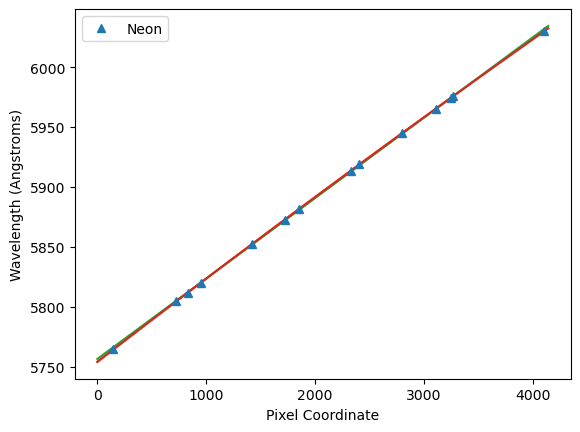

In [27]:
pl.plot(improved_xval_guesses_ne, ne_wl_final, '^', label='Neon')
pl.plot(xaxis, wavelengths_refit, zorder=-5)
pl.plot(xaxis, linfit_wlmodel(xaxis), zorder=-5)
pl.plot(xaxis, fitted_polymodel(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (Angstroms)");

Text(0, 0.5, 'Wavelength residual (data minus model; nm)')

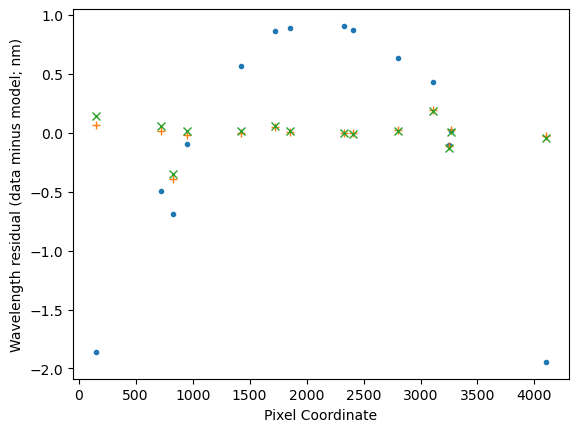

In [28]:
pl.plot(improved_xval_guesses_ne, ne_wl_final - linfit_wlmodel(improved_xval_guesses_ne), '.')
pl.plot(improved_xval_guesses_ne, ne_wl_final - fitted_polymodel(improved_xval_guesses_ne), '+')
pl.plot(improved_xval_guesses_ne, ne_wl_final - refitted_polymodel(improved_xval_guesses_ne), 'x')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength residual (data minus model; nm)")

# Plot final wavelength solution

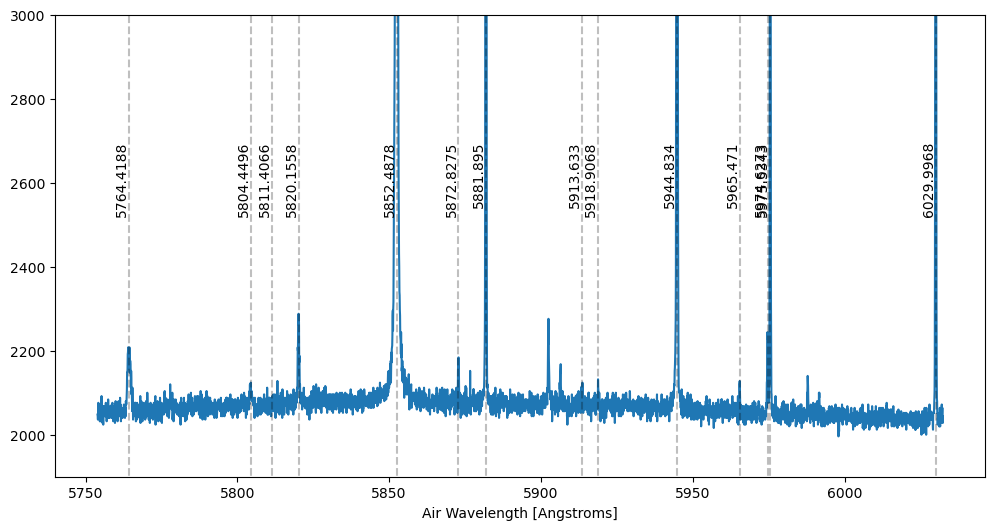

In [29]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, ne_spectrum)
pl.vlines(neon_lines['Observed'][ne_keep_final], 0, 62500, 'k', alpha=0.25, linestyle='--')
for wl in neon_lines['Observed'][ne_keep_final]:
    pl.text(wl, 2700, str(wl), rotation=90, ha='right', va='top')
pl.ylim(1900, 3000);
pl.xlabel("Air Wavelength [Angstroms]");

# Now we apply the solution to the solar spectrum

In [30]:
na_lines = Nist.query(minwav=minwave,
                      maxwav=maxwave,
                      wavelength_type='vac+air',
                      linename='Na I')

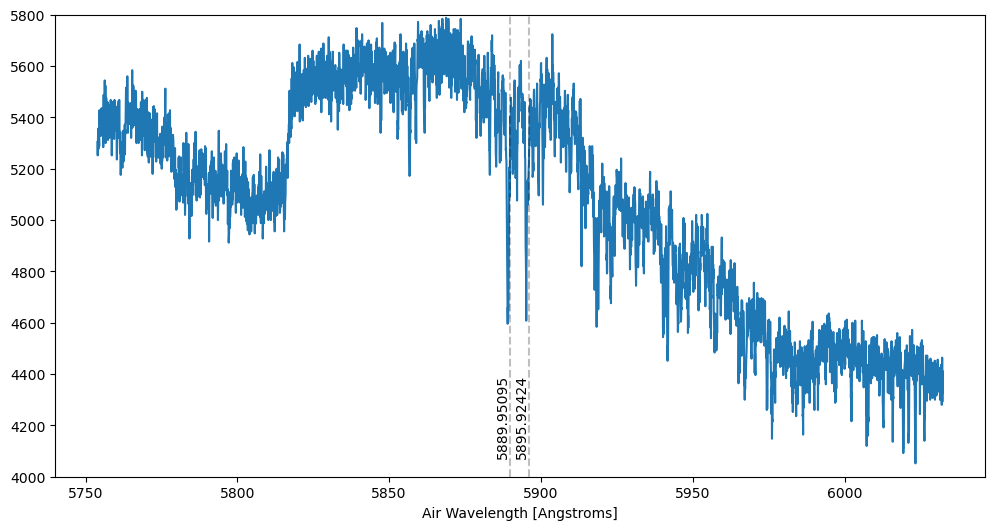

In [31]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, solar_image[1200,:])
pl.vlines(na_lines['Observed'], 4000, 6000, 'k', alpha=0.25, linestyle='--')
for wl in na_lines['Observed']:
    pl.text(wl, 4400, str(wl), rotation=90, ha='right', va='top')
pl.xlabel("Air Wavelength [Angstroms]");
pl.ylim([4000,5800]);

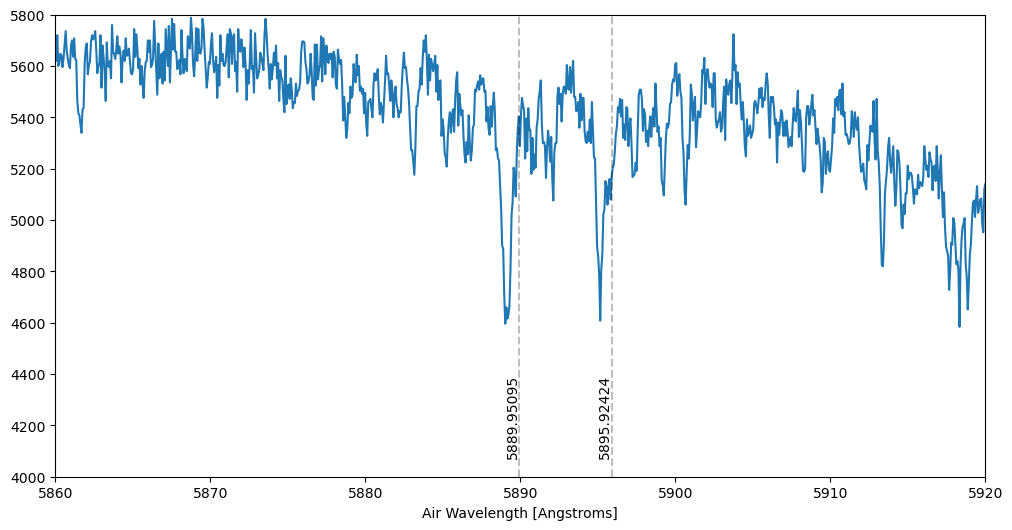

In [32]:
pl.figure(figsize=(12, 6))
pl.plot(wavelengths_refit, solar_image[1200,:])
pl.vlines(na_lines['Observed'], 4000, 6000, 'k', alpha=0.25, linestyle='--')
for wl in na_lines['Observed']:
    pl.text(wl, 4400, str(wl), rotation=90, ha='right', va='top')
pl.xlabel("Air Wavelength [Angstroms]");
pl.ylim([4000,5800]);
pl.xlim(5860,5920);